# Test deployed web application

This notebook pulls some images and tests them against the deployed web application on AKS.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from testing_utilities import *
import requests

%matplotlib inline

Get the external url for the web application running on AKS cluster.

In [2]:
service_json = !kubectl get service azure-dl -o json
service_dict = json.loads(''.join(service_json))
app_url = service_dict['status']['loadBalancer']['ingress'][0]['ip']
app_url

'52.224.106.118'

Quickly check if the web application is working.

In [3]:
scoring_url = 'http://{}/score'.format(app_url)
version_url = 'http://{}/version'.format(app_url)
health_url = 'http://{}/'.format(app_url)

In [4]:
!curl $health_url

Healthy

In [5]:
!curl $version_url # Reports the tensorflow version

1.4.1

Pull an image of a Lynx to test it with.

In [6]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"

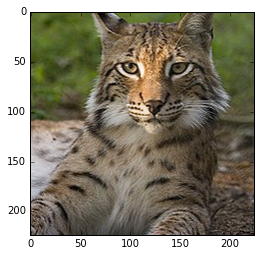

In [7]:
plt.imshow(to_img(IMAGEURL))

In [8]:
jsonimg = img_url_to_json_dict(IMAGEURL)
headers = {'content-type': 'application/json'}
r = requests.post(scoring_url, data=jsonimg, headers=headers) # Run the request twice since the first time takes a 
%time r = requests.post(scoring_url, data=jsonimg, headers=headers) # little longer due to the loading of the model
print(r)
r.json()

CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 300 ms
<Response [200]>


{'result': "([{'220px-Lynx_lynx_poing.jpg': [('n02127052', 'lynx', 0.9816483), ('n02128385', 'leopard', 0.0077441777), ('n02123159', 'tiger_cat', 0.0036861517)]}], 'Computed in 105.83 ms')"}

From the results above we can see that the model correctly classifies this as an Lynx. 

Let's try a few more images.

In [9]:
images = ('https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/3/3a/Roadster_2.5_windmills_trimmed.jpg',
          'http://www.worldshipsociety.org/wp-content/themes/construct/lib/scripts/timthumb/thumb.php?src=http://www.worldshipsociety.org/wp-content/uploads/2013/04/stock-photo-5495905-cruise-ship.jpg&w=570&h=370&zc=1&q=100',
          'http://yourshot.nationalgeographic.com/u/ss/fQYSUbVfts-T7pS2VP2wnKyN8wxywmXtY0-FwsgxpiZv_E9ZfPsNV5B0ER8-bOdruvNfMD5EbP4SznWz4PYn/',
          'https://cdn.arstechnica.net/wp-content/uploads/2012/04/bohol_tarsier_wiki-4f88309-intro.jpg',
          'http://i.telegraph.co.uk/multimedia/archive/03233/BIRDS-ROBIN_3233998b.jpg')

In [10]:
results = [requests.post(scoring_url, data=img_url_to_json_dict(img), headers=headers) for img in images]

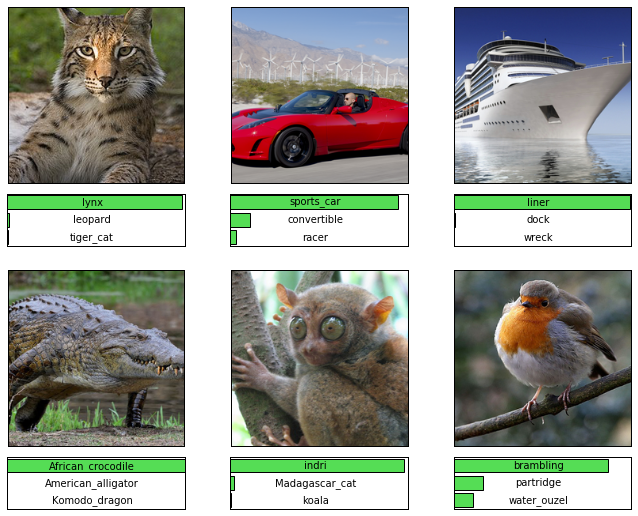

In [11]:
plot_predictions_dict(images, results)

The labels predicted by our model seem to be consistent with the images supplied.

Next let's quickly check what the request response performance is for the deployed model on AKS cluster.

In [12]:
image_data = list(map(img_url_to_json_dict, images)) # Retrieve the images and data

In [13]:
timer_results = list()
for img in image_data:
    res=%timeit -r 1 -o -q requests.post(scoring_url, data=img, headers=headers)
    timer_results.append(res.best)

In [14]:
timer_results

[0.35433908738195896,
 0.255114559084177,
 0.30878548696637154,
 0.2873420752584934,
 0.31211895775049925,
 0.2873007748275995]

In [15]:
print('Average time taken: {0:4.2f} ms'.format(10**3 * np.mean(timer_results)))

Average time taken: 300.83 ms


We have tested that the model works and we can now move on to the [next notebook to get a sense of its throughput](06_SpeedTestWebApp.ipynb).